# Project: The Movie Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Movies have become integral part of our life. Every movie enthusiast tries to predict the success of movie before its release. Profit is a key force in the movie industry, due to the costly and risky nature of filmmaking. The dataset **The Movie DataBase** which is taken from [kaggle](https://www.kaggle.com/tmdb/tmdb-movie-metadata). tries to explore the different parameters of movies which may govern the revenue of the movie.

In [1]:
#Essential packages required.
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

The data set contains one duplicate value, 1030 nullvalues in production companies, 5696 values are zero in budget and 6016 values are zero in revenue. The year format in release_date column is wrong for some movies which are ignored as there is seperate column for release_year.  
These values are dropped along with the unwanted columns  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;imdb_id', 'budget', 'revenue', 'cast', 'homepage', 'director', 'tagline', 'overview'

### General Properties

In [2]:
# Loading and inspecting the data
df_movie = pd.read_csv('tmdb_movies.csv')
df_movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

In [3]:
# Removes the duplicates.
df_movie.drop_duplicates(inplace=True)
df_movie.shape

(10865, 21)

In [4]:
# Removes the unwanted columns
label_col = ['imdb_id','budget','revenue','cast','homepage','director','tagline','overview']
df_movie.drop(label_col, axis=1, inplace=True)
df_movie.shape

(10865, 13)

In [5]:
# Removes any row with a NULL value
df_movie.dropna(axis=0, how='any', inplace=True)
df_movie.shape

(8701, 13)

In [6]:
# Removes rows with zero budget_adj and zero revenue_adj
df_movie.query('budget_adj != 0', inplace=True)
df_movie.query('revenue_adj != 0', inplace=True)
df_movie.shape

(3679, 13)

In [7]:
(df_movie['revenue_adj']==0).sum() #Checking whether the rows eith zero values are removed.

0

### Data Cleaning 

After removing unwanted columns and rows columns 'genres', 'produciton_companies', 'keywords' which are seperated by | are split into rows and columns release_year, release_date are converted into datetime types.

In [8]:
def SplitRows(df, column_name):
    """
    Splits into rows of a column named column_name from dataframe df with seperater | and removes the unwanted columns
    
    """
    df.index.name = 'index'
    df1 = df[column_name].str.split('|',expand=True).stack()
    df1.name = column_name+'_new'
    df2 = pd.DataFrame(df1)
    df2.index.levels[0].name = 'index'
    df3 = df.join(df2)
    df_split = df3.reset_index()
    df_split.drop(['index','level_1',column_name],axis=1,inplace=True)
    return df_split

In [9]:
#SpliRows of column-genres
df_genres = SplitRows(df_movie,'genres')
df_genres.shape

(9860, 13)

In [10]:
#SplitRows of column-keywords
df_keywords = SplitRows(df_genres,'keywords')

#SplitRows of column-production_companies
df_cleaned = SplitRows(df_keywords,'production_companies')
df_cleaned.shape

(123679, 13)

In [11]:
#Converts release_time column into timestamp
df_cleaned['release_date'] = df_cleaned['release_date'].apply(lambda x: datetime.strptime(x,'%m/%d/%y'))

#Converts the column release_year into str and then converts it into timestamp
df_cleaned['release_year'] = df_cleaned['release_year'].astype(str)
df_cleaned['release_year'] = df_cleaned['release_year'].apply(lambda x: datetime.strptime(x,'%Y'))

In [12]:
df_cleaned.nunique()

id                          3679
popularity                  3677
original_title              3634
runtime                      134
release_date                2798
vote_count                  1270
vote_average                  53
release_year                  56
budget_adj                  2039
revenue_adj                 3675
genres_new                    20
keywords_new                4800
production_companies_new    3153
dtype: int64

<a id='eda'></a>
## Exploratory Data Analysis




### Research Question 1  
 >**1**.The first question researches what type of genres are more frequent, what are the frequent keywords used and which production companies produced more movies.  

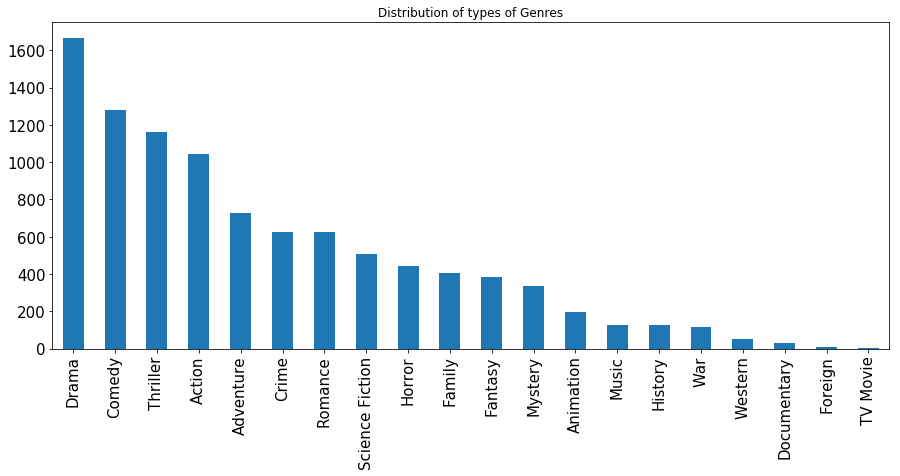

In [13]:
"""
Distribution of Genres over the entire dataset.

"""
plot_genres_bar = df_cleaned.groupby(['id','genres_new'],as_index=False).count().genres_new.value_counts()
plot_genres_bar.plot(kind='bar',figsize=(15,6),title='Distribution of types of Genres',fontsize=15);

Movies with genre-**Drama** are clearly highest in number.

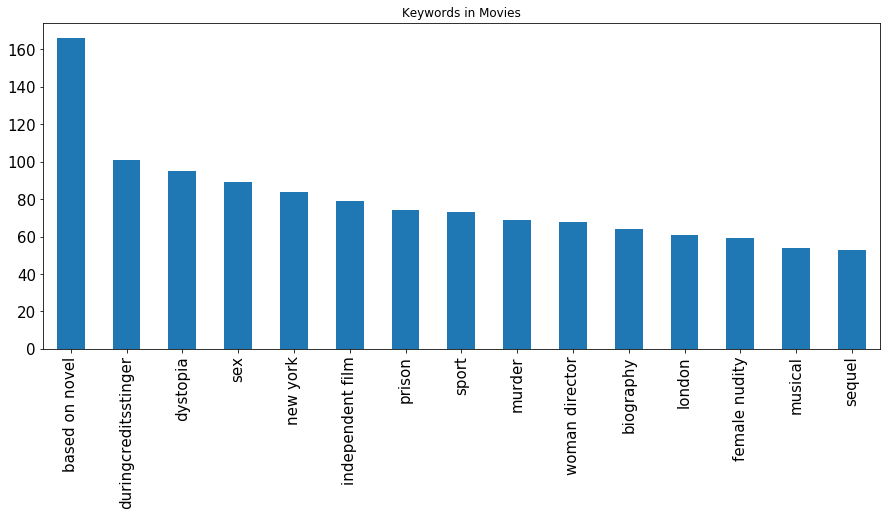

In [14]:
"""
Top 15 keywords in the movies

"""
plot_keywords_bar = df_cleaned.groupby(['id','keywords_new'],as_index=False).count().keywords_new.value_counts().head(15)
plot_keywords_bar.plot(kind='bar',figsize=(15,6),title='Keywords in Movies',fontsize=15);

Movies **'Based on novel'** are highest in number by a large margin and remaining keywords *decrease* gradually.

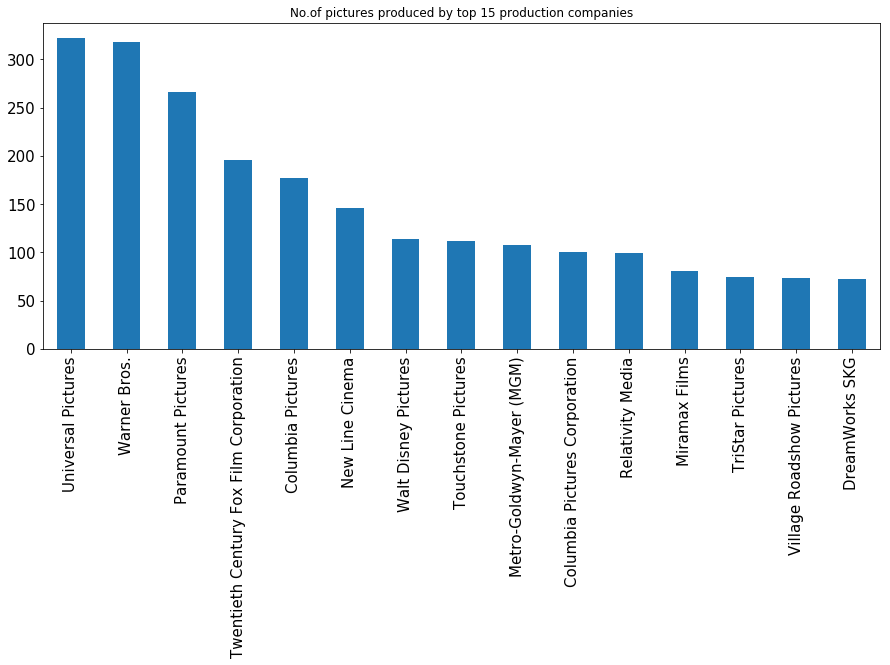

In [15]:
"""
Plot of Number of pictures produced by top 15 Production Companies.

"""
plot_production_bar = df_cleaned.groupby(['id','production_companies_new'],as_index=False).count().production_companies_new.value_counts().head(15)
plot_production_bar.plot(kind='bar',figsize=(15,6),title='No.of pictures produced by top 15 production companies',fontsize=15);

Production company **Universsal pictures** produced most number of pictures and immediately followed by **Warner Bros** with a very little difference.

### Research Question 2  

The revenue_adjusted is ranked into four categories namely Low, Medium, High, Very High according to their respective percentile.

 >**2a**. The variation of mean of parametres popularity, vote_average, runtime and budget_adjusted is observed with respect to the revenue rank.   

 >**2b**. For the revenue rank 'Very High', how the variation of parameters genres, keywords and production companies is seen.  

In [16]:
"""
Bin edges are created for revenue_adj.

"""
min_val = df_cleaned['revenue_adj'].describe().iloc[3]
low = df_cleaned['revenue_adj'].describe().iloc[4]
medium = df_cleaned['revenue_adj'].describe().iloc[5]
high = df_cleaned['revenue_adj'].describe().iloc[6]
max_val = df_cleaned['revenue_adj'].describe().iloc[7]
bin_edges = [min_val,low,medium,high,max_val]

"""
Creats a new column named revenue_rank to label the rank of the movie based on reveue_adj.

"""
df_cleaned['revenue_rank'] = pd.cut(df_cleaned['revenue_adj'], bins=bin_edges, labels=['Low','Medium','High','Very High'],include_lowest=True)

In [17]:
"""
The table shows the variation of mean of various columns with revenue_rank.

"""
df_cleaned.groupby(['id','revenue_rank'],as_index=False).mean().groupby(['revenue_rank'],as_index=False).mean().loc[:,['revenue_rank','popularity','runtime','vote_average','budget_adj']]

,revenue_rank,popularity,runtime,vote_average,budget_adj
0,Low,0.601593,103.936364,5.965909,1.877625e+07
1,Medium,0.900453,107.494428,6.097771,3.326189e+07
2,High,1.308758,111.304604,6.259858,5.164449e+07
3,Very High,2.482458,118.621477,6.526174,9.351522e+07


Parameters popularity, vote_average, runtime and budget increase with the increase in revenue rank. 

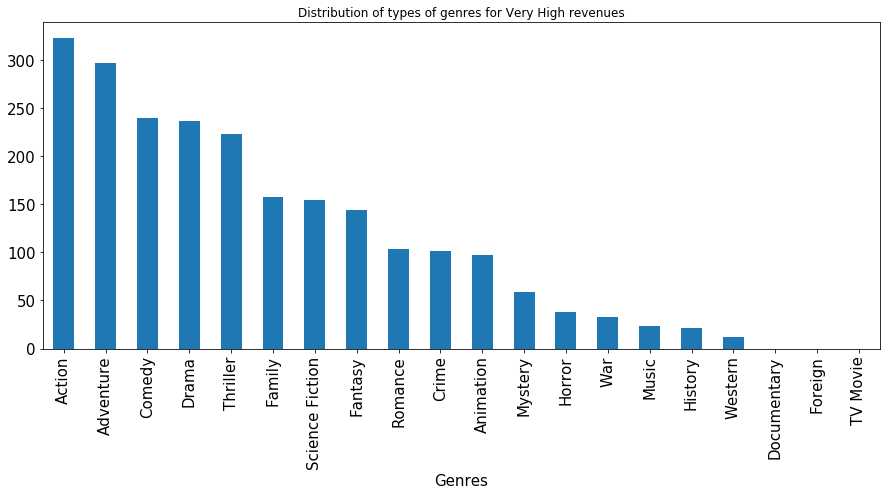

In [18]:
"""
Plots variation of counts of types of genres varied for respective revenue bins.

"""
df_rev_gen = df_cleaned.groupby(['id','revenue_rank','genres_new'],as_index=False).count().dropna().groupby(['revenue_rank','genres_new'],as_index=False).count()
plot_rev_gen = df_rev_gen.query('revenue_rank == "Very High"').loc[:,['genres_new','id']].sort_values('id',ascending=False)
plot_rev_gen.plot.bar(x='genres_new',y='id',legend=None,figsize=(15,6),title='Distribution of types of genres for Very High revenues',fontsize=15);
plt.xlabel('Genres',fontsize=15);

Number of movies with Genre-**Action** is highest for 'Very High' revenue category followed by Genre-**Adventure**.

In [19]:
"""
Seperate datafrmae of df_key is created for production_companies and sorted into bins 
of revenue as computations on df_cleaned is giving memory error.

"""
df_pdn = SplitRows(df_movie,'production_companies')
df_pdn['revenue_rank'] = pd.cut(df_pdn['revenue_adj'], bins=bin_edges, labels=['Low','Medium','High','Very High'],include_lowest=True)

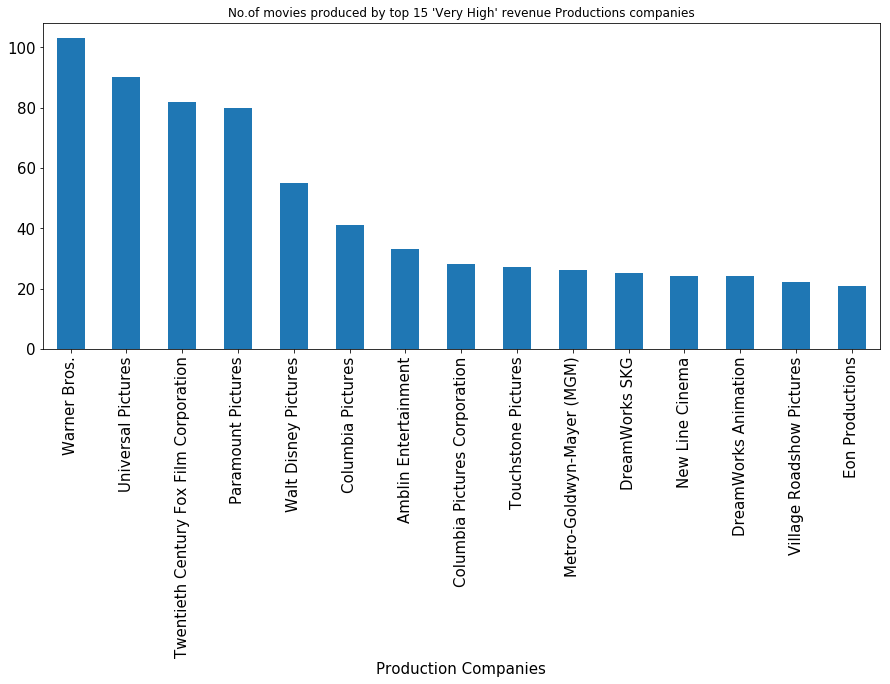

In [20]:
"""
Plot for No.of movies produced by top 15 'Very High' revenue Productions companies.

"""
df_pdn_grp = df_pdn.groupby(['revenue_rank','production_companies_new'],as_index=False).count().dropna()
plot_pdn = df_pdn_grp.query('revenue_rank == "Very High"').loc[:,['production_companies_new','id']].sort_values('id',ascending=False).head(15)
plot_pdn.plot(x='production_companies_new',y='id',legend=None,kind='bar',figsize=(15,6),title="No.of movies produced by top 15 'Very High' revenue Productions companies",fontsize=15);
plt.xlabel('Production Companies',fontsize=15);

Highest rank revenue movies are produced by **Warners Bros** and followed by **Universal Pictures**. 

In [21]:
"""
Seperate datafrmae of df_key is created for keywords and sorted into bins 
of revenue as computations on df_cleaned is giving memory error.

"""
df_key = SplitRows(df_movie,'keywords')
df_key['revenue_rank'] = pd.cut(df_key['revenue_adj'], bins=bin_edges, labels=['Low','Medium','High','Very High'],include_lowest=True)

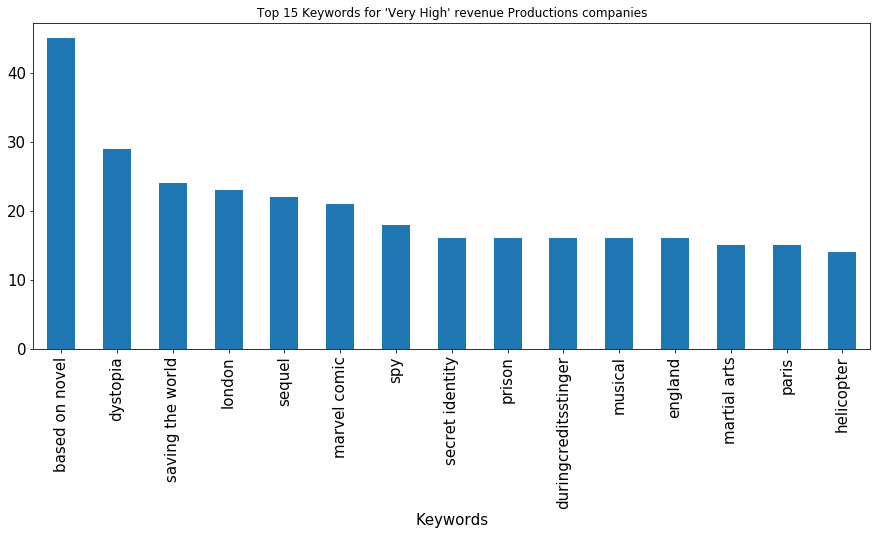

In [22]:
"""
Plot for Top 15 Keywords for 'Very High' revenue Productions companies.

"""
df_key_grp = df_key.groupby(['revenue_rank','keywords_new'],as_index=False).count().dropna()
plot_key = df_key_grp.query('revenue_rank == "Very High"').loc[:,['keywords_new','id']].sort_values('id',ascending=False).head(15)
plot_key.plot(x='keywords_new',y='id',legend=None,kind='bar',figsize=(15,6),title="Top 15 Keywords for 'Very High' revenue Productions companies",fontsize=15);
plt.xlabel('Keywords',fontsize=15);

For 'Very High' revenue category clearly keyword **'based on novel'** is highest.

## Research Question 3
 >**3a**. Top 15 years with highest number of movie releases.   

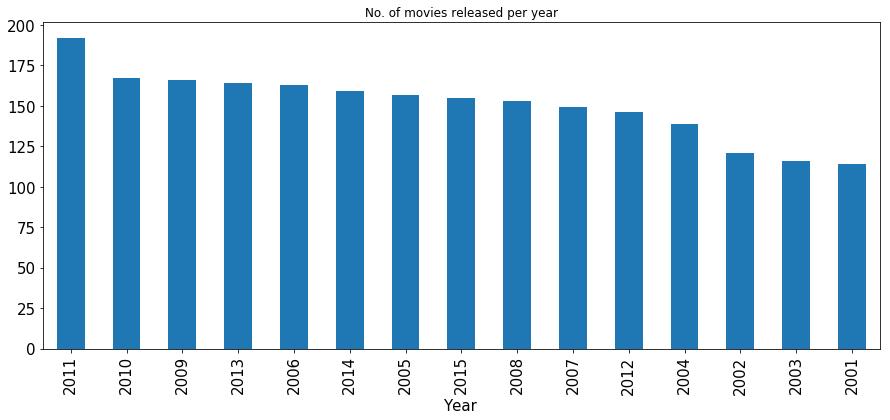

In [23]:
"""
Plot for variation of top 15 number of movies released per year.

"""
df_clnd_year = df_cleaned.groupby(['id','release_year'],as_index=False).count().groupby(['release_year'],as_index=False).count()
df_clnd_year_plot = df_clnd_year.loc[:,['release_year','id']].sort_values('id',ascending=False).head(15)
df_clnd_year_plot.plot.bar(x=df_clnd_year_plot['release_year'].dt.year,y='id',legend=None,figsize=(15,6),title="No. of movies released per year",fontsize=15);
plt.xlabel('Year',fontsize=15);

The year 2011 saw the highest number of releases and *top 15 years are from 21st century*. 

 >**3b**. Variation of number of movies released in a year. 

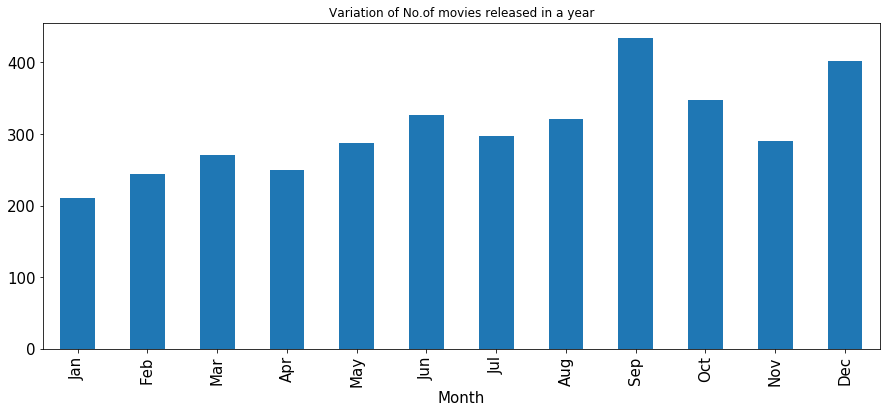

In [24]:
"""
Plot for Variation of Number of movies released in a year.

"""
dm = df_cleaned.groupby(['id',df_cleaned['release_date'].dt.month]).count().groupby(level=[1]).count()
loc = range(0,12)
xticks = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
pd.DataFrame(dm.popularity).plot(kind='bar',legend=None,figsize=(15,6),title='Variation of No.of movies released in a year',fontsize=15);
plt.xticks(loc,xticks);
plt.xlabel('Month',fontsize=15);

**September** saw the movies with highest number of releases while January has the lowest releases.

 >**3c**. Variation of number of movies releases in a year for each revenue rank.

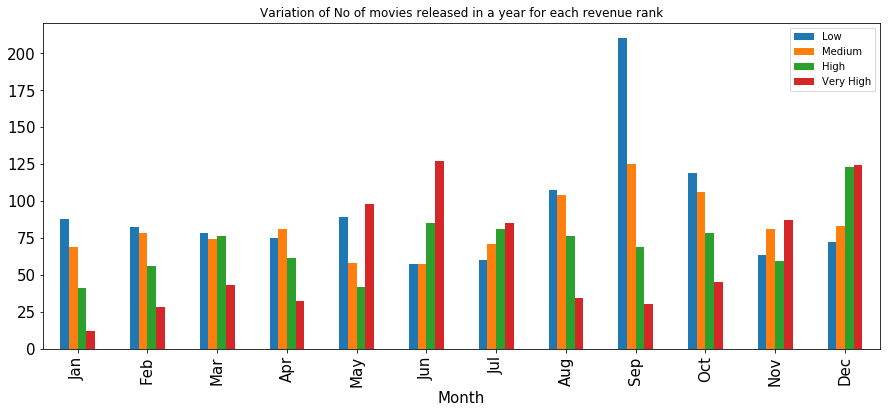

In [25]:
"""
Plot for number of types of movies released in a year for each revenue_rank.

"""
dm_rev = df_cleaned.groupby(['id',df_cleaned['release_date'].dt.month,'revenue_rank']).count().dropna().groupby(level=['release_date','revenue_rank']).count()
pd.DataFrame(dm_rev.popularity).unstack(1).plot(kind='bar',figsize=(15,6),title='Variation of No of movies released in a year for each revenue rank',fontsize=15);
plt.legend(['Low','Medium','High','Very High']);
plt.xticks(loc,xticks);
plt.xlabel('Month',fontsize=15);

**'Very High'** revenue movies are released during **July** followed by December and May. Interestingly, movies with **'Low'** revenue rank are released during **September** by a large margin.

 >**3d**. Variation of budget across years. 

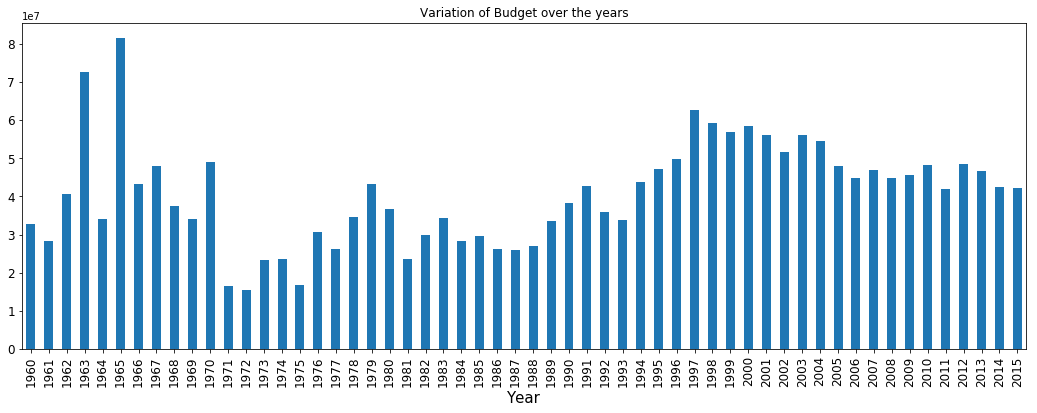

In [26]:
"""
Plot for Variation of Budget across the years.

"""
df_bdj_yr = df_cleaned.groupby(['id','release_year'],as_index=False).mean().loc[:,['release_year','budget_adj']].groupby(['release_year'],as_index=False).mean()
df_bdj_yr.plot.bar(x=df_bdj_yr['release_year'].dt.year,y='budget_adj',legend=None,figsize=(18,6), title='Variation of Budget over the years',fontsize=12);
plt.xlabel('Year',fontsize=15);

Years with highest budget are released during **1960's** and there is sudden decrese during 1970's. Lately, there is little change in budget.

 >**3e**. Variation of revnue across years. 

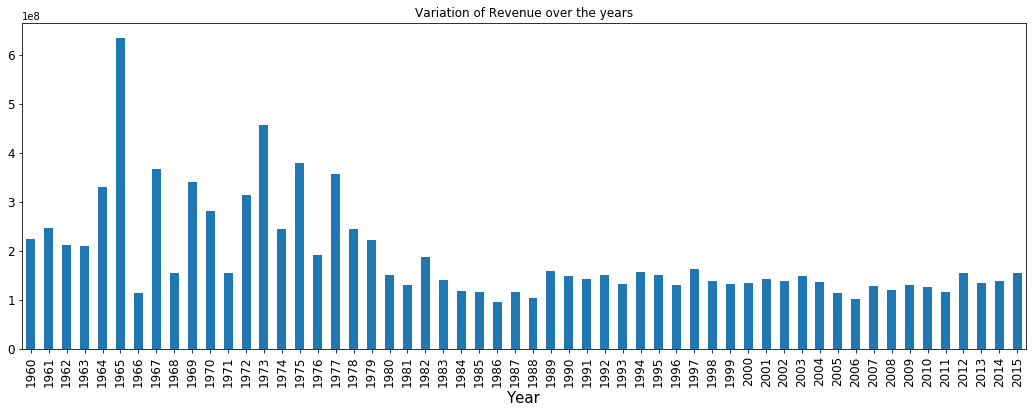

In [27]:
"""
Plot for Variation of Revenue across the years.

"""
df_rev_yr = df_cleaned.groupby(['id','release_year'],as_index=False).mean().loc[:,['release_year','revenue_adj']].groupby(['release_year'],as_index=False).mean()
df_rev_yr.plot.bar(x=df_bdj_yr['release_year'].dt.year,y='revenue_adj',legend=None,figsize=(18,6), title='Variation of Revenue over the years',fontsize=12);
plt.xlabel('Year',fontsize=15);

For revenue, **highest peakes** are seen during **1960's** and **1970's** but after 1980's the revenues have decreased and there is little change after that.

 >**3f**. Variation of runtime across years.  

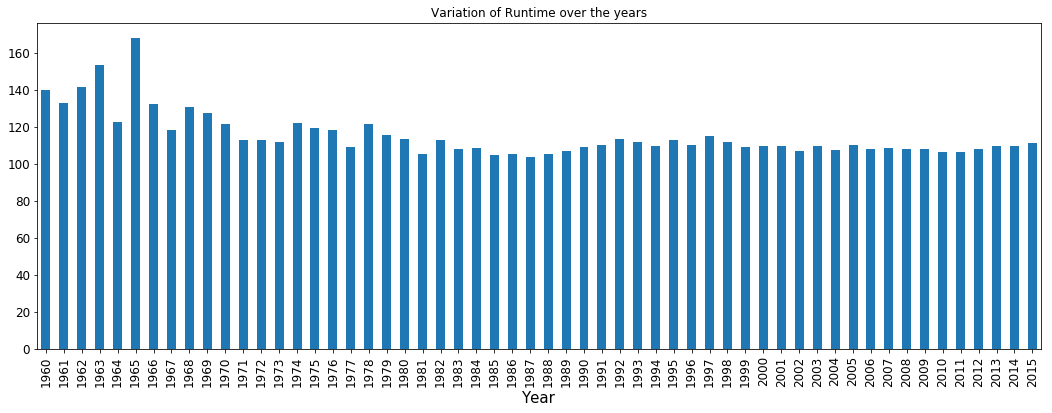

In [28]:
"""
Plot for Variation of runtime across the years.

"""
df_run_yr = df_cleaned.groupby(['id','release_year'],as_index=False).mean().loc[:,['release_year','runtime']].groupby(['release_year'],as_index=False).mean()
df_run_yr.plot.bar(x=df_bdj_yr['release_year'].dt.year,y='runtime',legend=None,figsize=(18,6), title='Variation of Runtime over the years',fontsize=12);
plt.xlabel('Year',fontsize=15);

As expected, runtime of movies haven't changed much.

## Research Qustion 4
The vot_avg is ranked into four categories namely Bad, Average, Good, Excellent according to their respective percentile.  

 >**4a**. How genres are ranked based on vote_average.

In [29]:
"""
Bin edges are created for vote_average.

"""
min_val_va = df_cleaned['vote_average'].describe().iloc[3]   # Minimum value     
low_va = df_cleaned['vote_average'].describe().iloc[4]  # 25th percentile value
medium_va = df_cleaned['vote_average'].describe().iloc[5]  # 50th percentile value
high_va = df_cleaned['vote_average'].describe().iloc[6]  # 75th percentile value
max_val_va = df_cleaned['vote_average'].describe().iloc[7]  # Maximum value
bin_edges_va = [min_val_va,low_va,medium_va,high_va,max_val_va]

"""
New column vote_avg_rank is created for ranking the movies according to vote average.

"""
df_cleaned['vote_avg_rank'] = pd.cut(df_cleaned['vote_average'], bins=bin_edges_va, labels=['Bad','Average','Good','Excellent'],include_lowest=True)

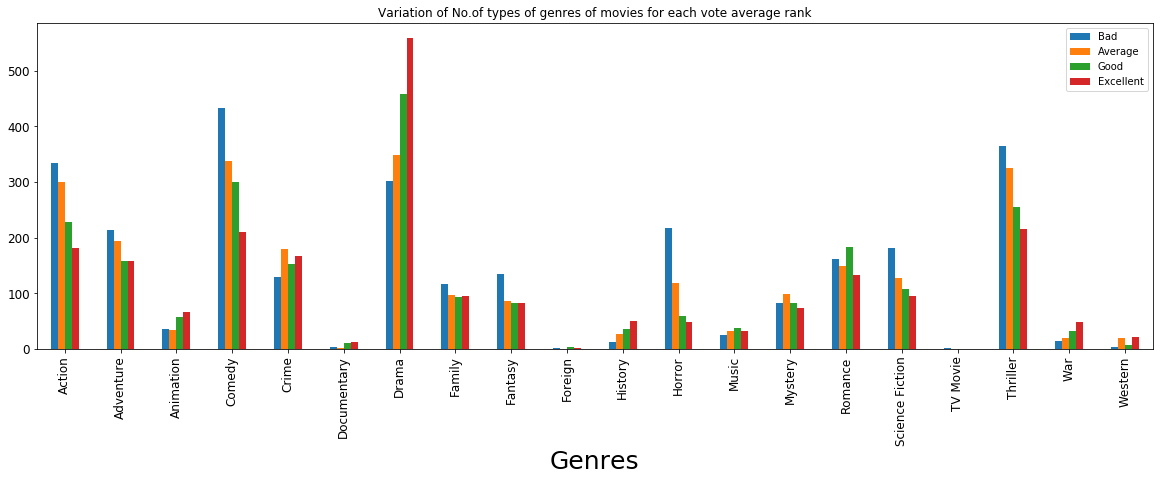

In [30]:
"""
Plor for variation of number of types of genres of movies for each vote average rank.

"""
plt_va_genre = df_cleaned.groupby(['id','genres_new','vote_avg_rank'],as_index=False).count().dropna().groupby(['genres_new','vote_avg_rank']).count()
pd.DataFrame(plt_va_genre['id']).unstack(1).plot(kind='bar',figsize=(20,6),title='Variation of No.of types of genres of movies for each vote average rank',fontsize=12);
plt.legend(['Bad','Average','Good','Excellent']);
plt.xlabel('Genres',fontsize=25);

Movies with 'Excellent' vote_average are from genre-**Drama** while movies with 'Low' vote_average are from *Comedy* and immediately followed by *Action* and *Thriller.* 

 >**4b**. Movies produced by top 15 Productions companies with 'Excellent' vote average. 

In [31]:
"""
As df_cleaned dataframe is displaying Memory error when grouping by 
production_companies_new, vote_avg_rank the df_pdn dataframe is used.

New column 'vote_avg_rank' is created for ranking the movies according to vote average.

"""
df_pdn['vote_avg_rank'] = pd.cut(df_pdn['vote_average'],bins=bin_edges_va,labels=['Bad','Average','Good','Excellent'],include_lowest=True)

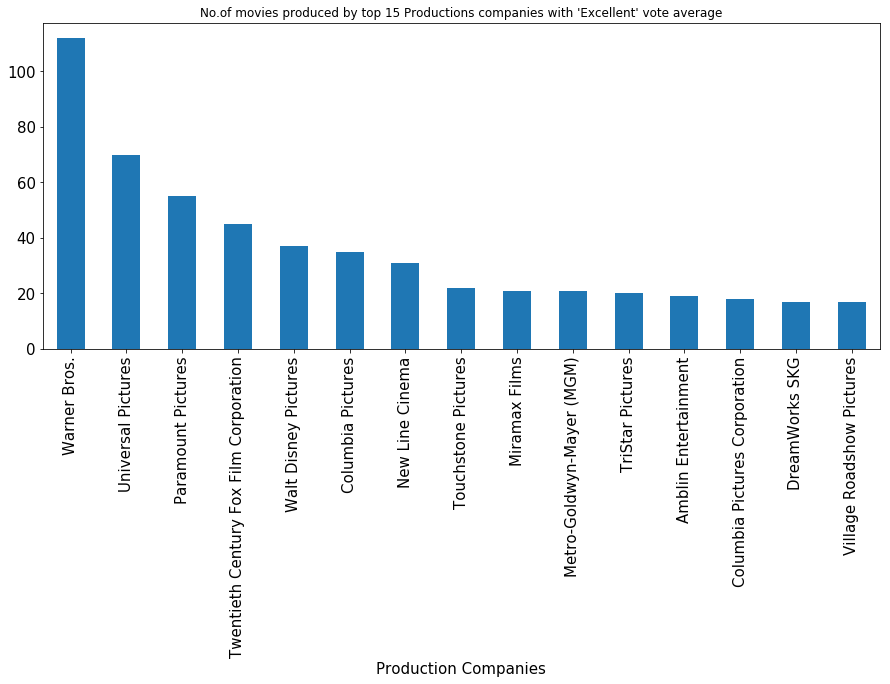

In [32]:
"""
Plor for number of movies produced by top 15 Productions companies with 'Excellent' vote average.

"""
df_plot_va = df_pdn.groupby(['production_companies_new','vote_avg_rank'],as_index=False).count().dropna()
plot_va = df_plot_va.query('vote_avg_rank=="Excellent"').loc[:,['production_companies_new','id']].sort_values('id',ascending=False).head(15)
plot_va.plot.bar(x='production_companies_new',y='id',legend=None,figsize=(15,6),title="No.of movies produced by top 15 Productions companies with 'Excellent' vote average",fontsize=15);
plt.xlabel('Production Companies',fontsize=15);

The production company with highest number of movies with 'Excellent' vote_average is **Warner Bros**.

 >**4c**. Comparing how 'Very High' and 'Low' revenue rank movies are ranked with respect to vote_avg_rank.

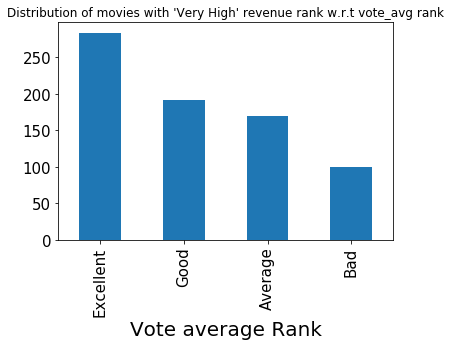

In [33]:
"""
Plot showing how the 'Very High' revenue_rank is distributed for vote_avg_rank.

"""
df_pdn_drp = df_pdn.drop_duplicates('id')
df_pdn_drp.query('revenue_rank == "Very High"').vote_avg_rank.value_counts().plot(kind='bar',fontsize=15,title="Distribution of movies with 'Very High' revenue rank w.r.t vote_avg rank");
plt.xlabel('Vote average Rank',fontsize=20);

Interestingly, for movies with revenue rank 'Very High' there are around 100 movies with 'Bad' vote_average.

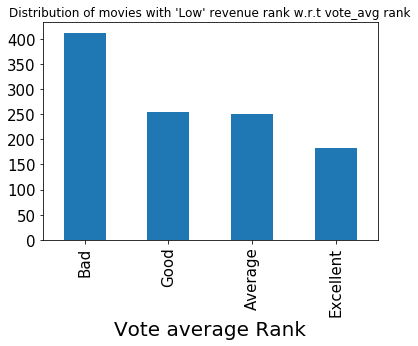

In [34]:
"""
Plot showing how the 'Low' revenue_rank is distributed for vote_avg_rank.

"""
df_pdn_drp.query('revenue_rank == "Low"').vote_avg_rank.value_counts().plot(kind='bar',fontsize=15,title="Distribution of movies with 'Low' revenue rank w.r.t vote_avg rank");
plt.xlabel('Vote average Rank',fontsize=20);

Similarly, for movies with revenue rank 'Low' there are around 250movies with 'Good' vote_avg rank and around 175 movies with 'Excellent' vote_avg rank.

## Research Qustion 5
 >Scatter plots between runtime, budget_adj, vote_average ad revenue_adj.

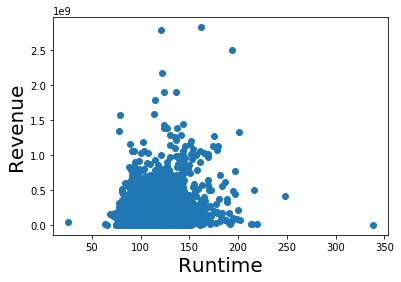

In [35]:
"""
Scatter plot for revenue_adj and runtime.

"""
run_sctr = df_cleaned.groupby(['id','runtime','revenue_adj'],as_index=False).mean()
plt.scatter(run_sctr.runtime, run_sctr.revenue_adj);
plt.xlabel('Runtime',fontsize=20);
plt.ylabel('Revenue',fontsize=20);

As expected there is no correlation between runtime and revenue.

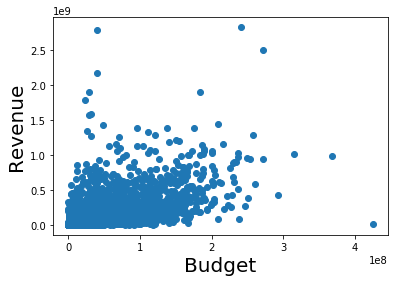

In [36]:
"""
Scatter plot for revenue_adj and budget_adj.

"""
plt.scatter(run_sctr.budget_adj,run_sctr.revenue_adj);
plt.xlabel('Budget',fontsize=20);
plt.ylabel('Revenue',fontsize=20);

From the above scatter plot we can say that, there is no correlation between budget and revenue.

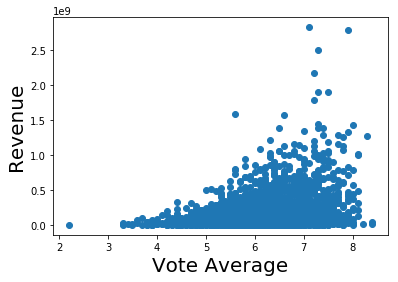

In [37]:
"""
Scatter plot for revenue_adj and vote_average.

"""
plt.scatter(run_sctr.vote_average,run_sctr.revenue_adj);
plt.xlabel('Vote Average',fontsize=20);
plt.ylabel('Revenue',fontsize=20);

From the scatter plot we can observe that there is a **weak correlation** between vote_average and revenue_adj.

<a id='conclusions'></a>
## Conclusions


<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Though from the first Question we can say that movies with genre-Drama are released more from the second Question we see that movies with genre-Action, Adventure and Comedy are high grossing movies. When the movies are ranked for vote average then Genre-Drama is clearly favourite and least favourite is Comedy.</p>
<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Movies based on novel are released highest in number as well as highest grossing movies.  
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;There is little difference in number of movies released between the production companies Universal Pictures and Warner Bros with Universal Pictures being at the top for number of releases. But for the movies with 'Very High' revenue rank Warner Bros overtakes Universal Pictures. When movies are ranked for vote average then for 'Excellent' vote average production company Warner Bros clearly beats Universal Pictures.</p>  
   
<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The top 15 years with highest number of movies releases are from 21st century (2001-2015).  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In a year month september has seen the highest number of releases. But for movies with 'Very High' revenue rank are released during July followed by December. Movies with revenue rank 'Low' were released during September. If we consider revenue ranks 'Very High' and 'High' then clearly *December is the successful month*.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The budget for the movies has been decreasing for the last 20 years but there is little change in revenue.</p>

> **Limitation**: Comparisions based on time of release and year of release may not be accurate because every movie that is released between 1960 and 2015 is not included and also with more number of movies in a year results in biased results.

<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Finally contrast is made between movies with 'Very High' revenue rank and movies with 'Low' revenue rank with vote average rank. Though the movies are ranked with 'Very High' revenue rank there are significant number of movies with 'Bad' vote average rank. Similarly for movies with 'Low' revenue rank there are huge number of movies with 'Good' and 'Excellent' vote average. We can say that not all movies which are 'Very High' revenue category are liked by viewers at the same time some movies with 'Low' revenue category are highly liked by viewers.</p>

<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;*The movie produced by Warner Bros or Universal Pictures released during July or December with combintion of genres Action, Adventure and Drama and movie 'based on novel' would more likely to have 'Very High' revenue and has Good or Excellent vote rank among viewers*.</p>

<p>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;As future scope a predictive model can be designed so that a viewer can get a fair idea whether the upcoming movies will be successfull or is it going to have good vote average or both.</p>

In [35]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0